# **Introduction to Business Analytics, Challenge Fall 2019**

This notebook is the first one of our report for the Challenge in Introduction to Business Analytics. The challenge is using a dataset from the city of Santiago de Chile. Our first task is to build a model allowing us to predict the variable 'CLASE' The second one is to raise a question from the data to get some relevant information about the data itself or the city. One important component of this project is that we are dealing with geographic data. Note that the quantity of domain knowledge about the data is relatively poor.

To tackle the issues presented before, we organized the work the following way. First, we have drawn some basic analysis and statistics about the data to determine what would be our next move. We also plotted a lot of visualization to get more concrete information about Santiago de Chile. That constitutes our first notebook. We even used some external data (e.g. voting data) to visualize the population distribution. 

The second notebook presents the best classifier we could build from the data using the Adaboost algorithm. Our investigation began with a naive classifier without much data manipulation. Then we tried to get more from the data we had notably using a PCA. Also, we used an external dataset to get more information about the neighborhood of each sample. 

The last notebook presents a small study about the accessibility in the city and concludes the Challenge. We tried to group the samples by zones and cluster them to differentiate several lifestyles and standards of living in the city and its surroundings. Moreover, we did the same kind of clustering but at a sample level. 

Good read,

Jules Belveze (s182291), Cyril Estok (s164562), Renaud Jester (s182269)

All members of the team have contributed equally for this Challenge.

# **Preliminary analysis and preprocessing for classification and exploration**

The notebook consists of 4 parts: Preparation, which focuses on data cleaning and preparation of the dataset for later use; Exploratory analysis, where the data are being examined, principal component analysis and preliminary feature selection is performed and Visual analysis, where data are visualized to gain some insights. Last part called Visual bonus includes bonus visualizations made with external datasets. 

Note: this notebook is run on googlecolab so some of the code reflect this feature by calling an API to collect data. 

## **Preparation**


### **Package import**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
!pip install geopandas pyshp;

     |████████████████████████████████| 921kB 2.7MB/s 
     |████████████████████████████████| 225kB 17.2MB/s 
     |████████████████████████████████| 11.8MB 195kB/s 
     |████████████████████████████████| 10.1MB 42.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32607 sha256=a8fa662bd6b8169491e657862624ad8f6e0bc54f8472b3dc07f2dfd755e30a36
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd
import numpy as np
import shapefile
from pyproj import Proj, transform
from sklearn.decomposition import PCA
from matplotlib import patches


In [0]:
folder_shape_files = 'drive/My Drive/shape-files-ds-for-mobility'
files = os.listdir(folder_shape_files)

### **Data collection and cleansing**

Some basic information about the dataset and cleaning.


In [0]:
df = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/776c1b404d59cfdf7896da9074246a18/raw/78bfa8bb98bbb0ce3c7eb074527e78eae9cf7c6e/Households%2520Data.csv", sep=';', error_bad_lines=False, decimal=',');

b'Skipping line 17: expected 30 fields, saw 31\nSkipping line 47: expected 30 fields, saw 58\n'


In [0]:
columns = df.columns.tolist()
print("Columns: {}".format(columns))
print("DataFrame shape: {}".format(df.shape))

Columns: ['Hogar', 'EXCLUIR', 'paraValidacion', 'Sector', 'DirCoordX', 'DirCoordY', 'MontoArr', 'IngresoHogar', 'Factor', 'AnosEstudio', 'CLASE', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM', 'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub', 'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto', 'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto', 'Acc_Servicios_auto', 'CLUSTER7', 'CLUSTER2']
DataFrame shape: (18292, 30)


In [0]:
# removing row to exclude
df = df[df['EXCLUIR'] == 0]

# removing not allowed columns
# we guessed that all the columns before 'CLASE' were to exclude
new_columns = columns[columns.index('CLASE'):]
df_filtered = df[new_columns]

df_filtered.head()

CLASE  Sup_Prom_Constr_Hab_EOD  ...  CLUSTER7  CLUSTER2
0      1                     53.8  ...         3         1
1      1                     59.6  ...         3         1
2      1                     59.5  ...         3         1
3      2                     59.5  ...         3         1
4      2                     43.6  ...         3         1

[5 rows x 20 columns]

## **Exploratory analysis**

In this section, we plot and print some statistics about the data and how variables relate to each other.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


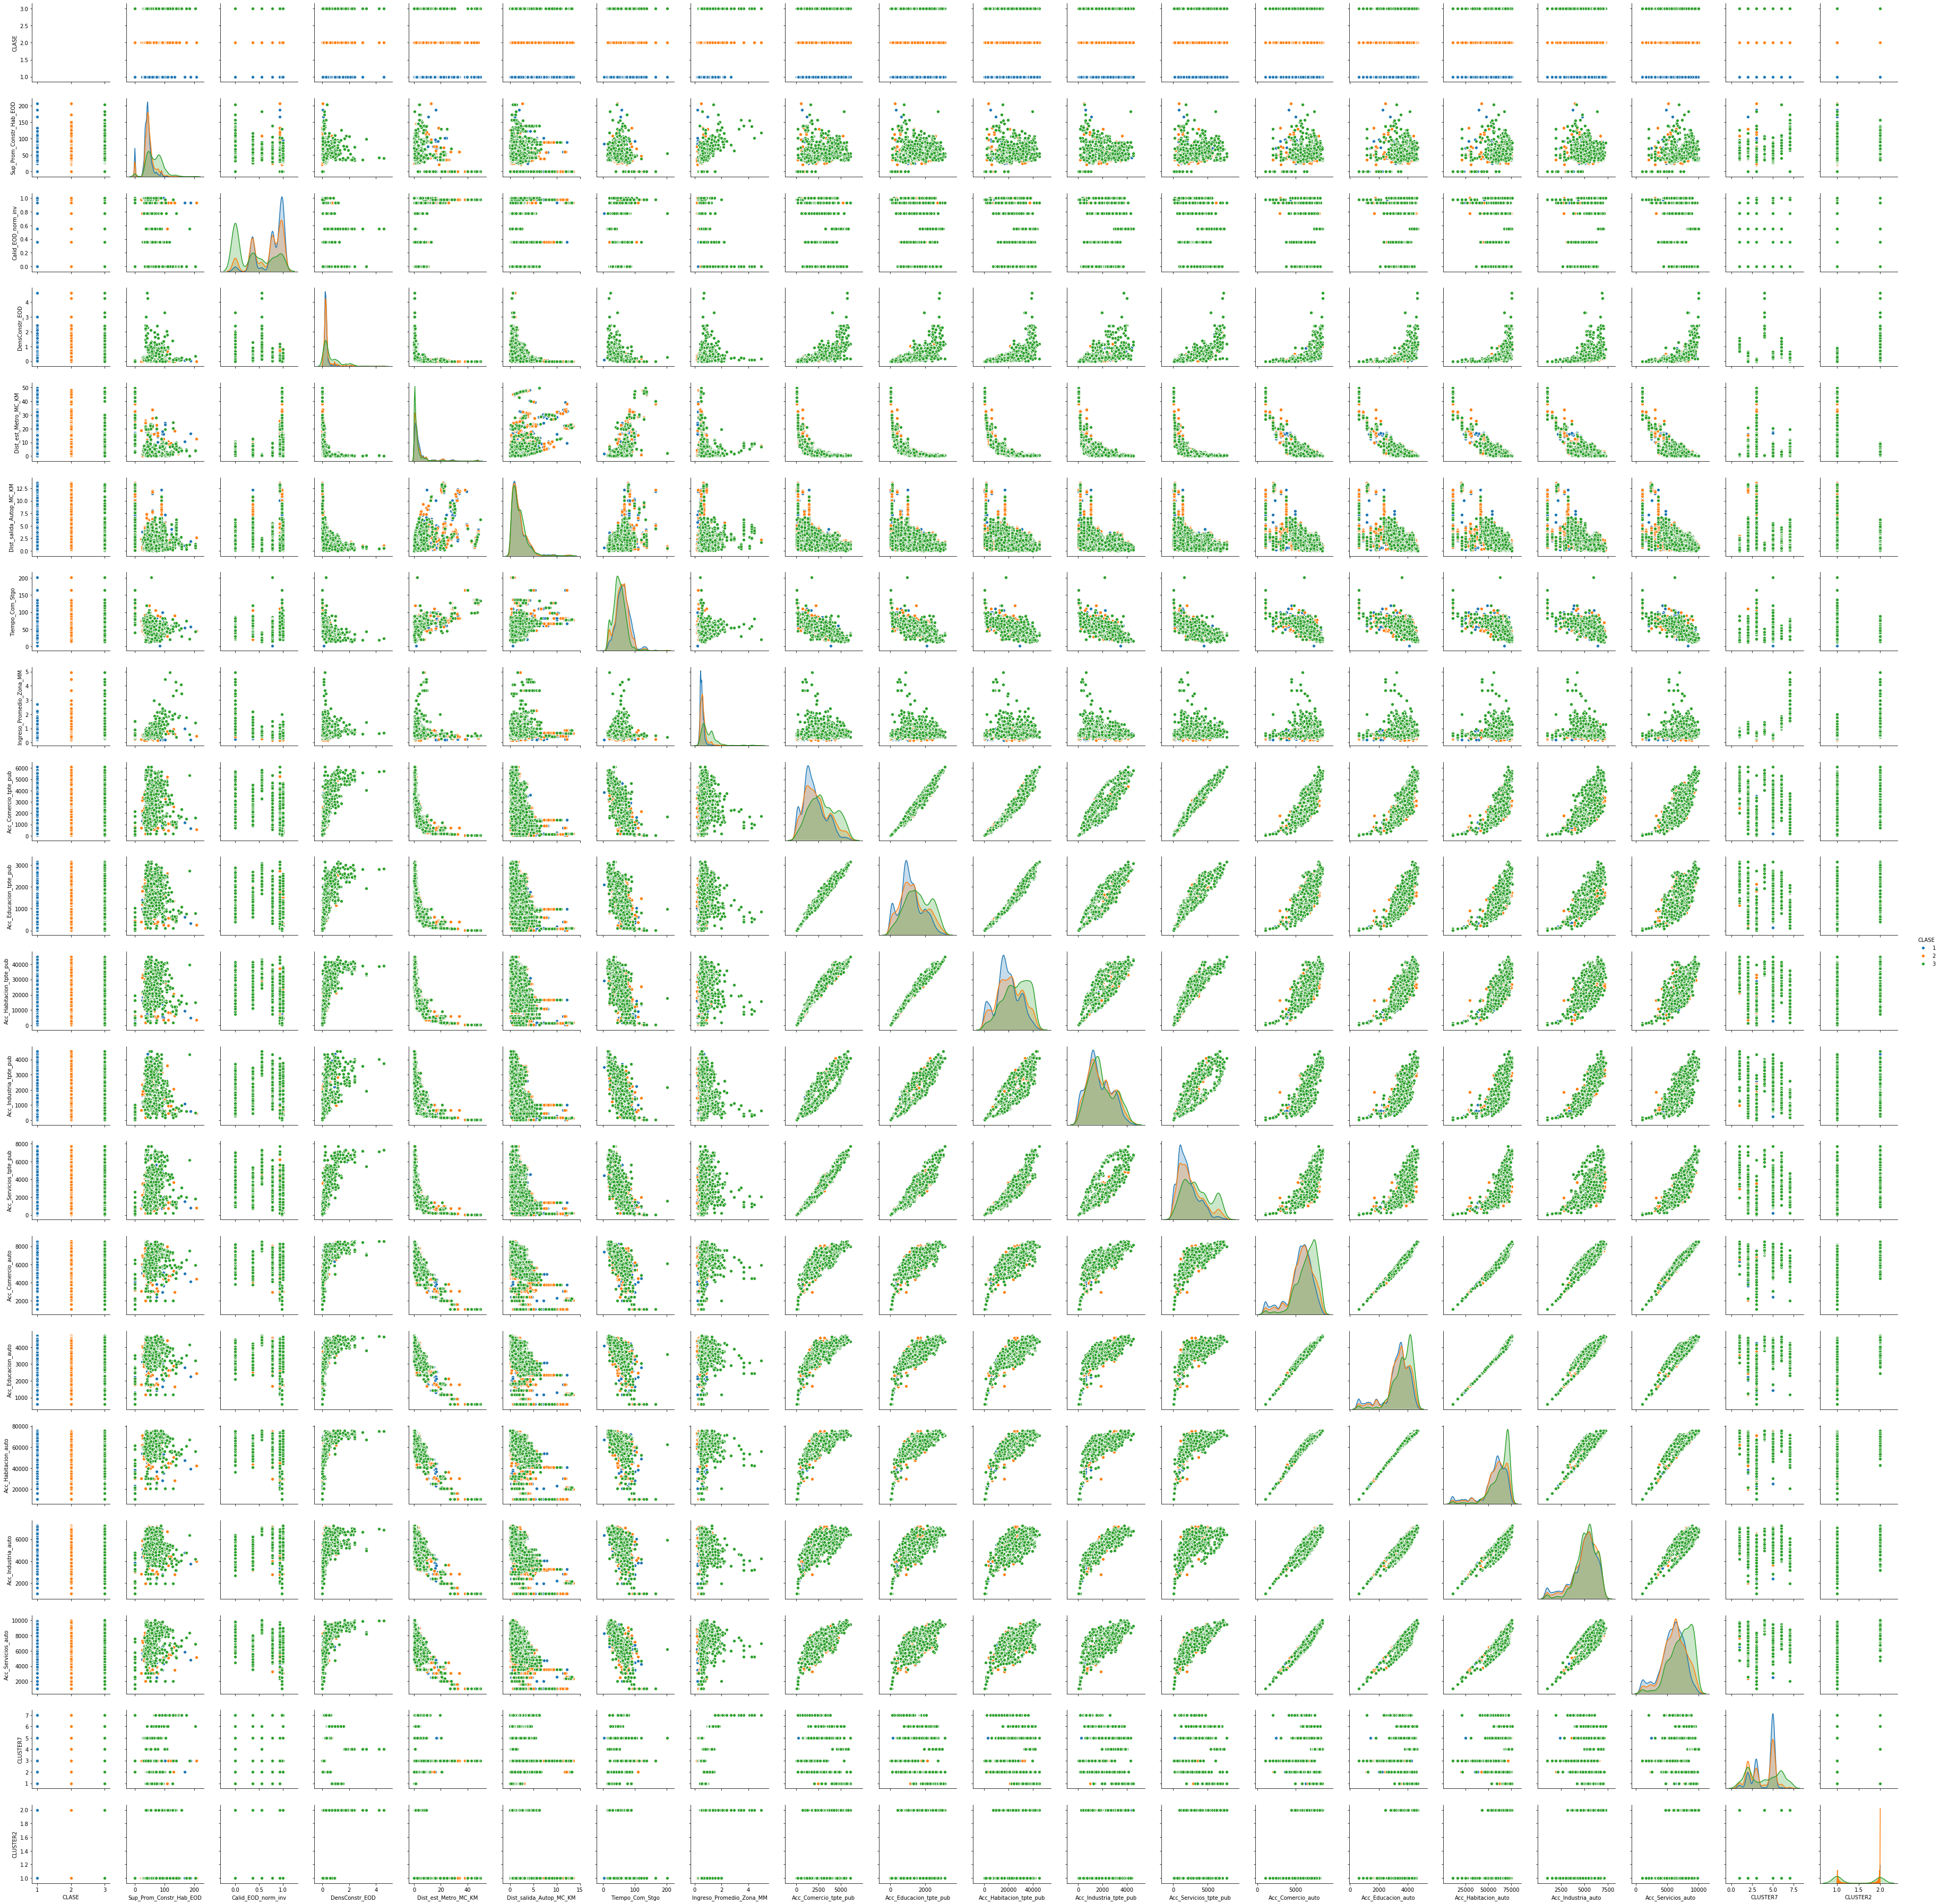

In [0]:
# Plot of all the varables by pairs
# We use different colors for the different values of 'CLASE'
sns.pairplot(df_filtered, hue='CLASE');

From the graph above we see that some of the variables are quite decorrelated to the target variable. Indeed on the diagonal we see that some of the variables present the same distribution for the three values of the target variable. Another observation is that a lot of the variables are correlated, something that we want to avoid. (especially the accessibilites)

Below we plot some more graphs that confirm what has been just said. We can observe the high correlation between the features whereas they are not that correlated with the target variable.

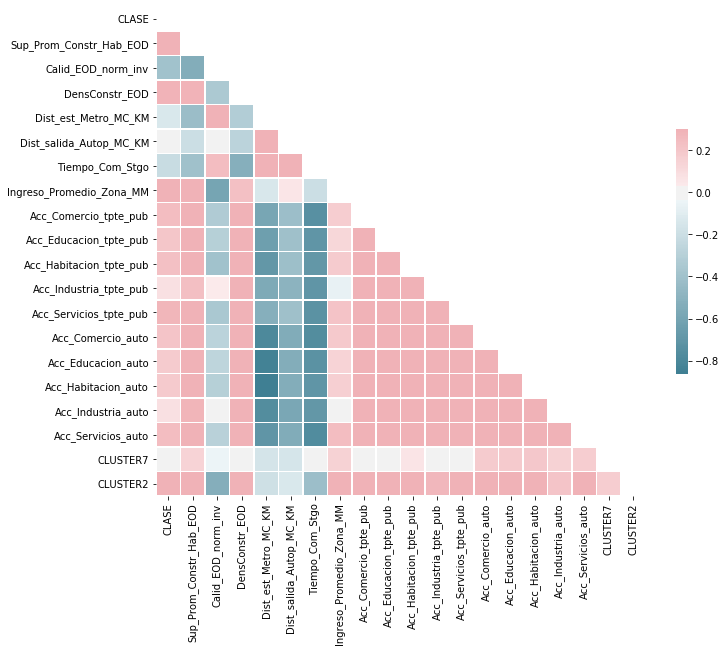

In [0]:
corr = df_filtered.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
# scaling the grouped by dataframe and plotting bars
# grouped_df = df_filtered.groupby("CLASE").transform(lambda x: (x - x.mean()) / x.std())
# grouped_df.plot.bar(figsize=(20,8), width=1);

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fd8ff686620> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
# target proportion in our data
print("Proportion CLASE 1: {}".format(df_filtered[df_filtered['CLASE']==1].shape[0]/df_filtered.shape[0]))
print("Proportion CLASE 2: {}".format(df_filtered[df_filtered['CLASE']==2].shape[0]/df_filtered.shape[0]))
print("Proportion CLASE 3: {}".format(df_filtered[df_filtered['CLASE']==3].shape[0]/df_filtered.shape[0]))

Proportion CLASE 1: 0.3720293641906184
Proportion CLASE 2: 0.43635684957073534
Proportion CLASE 3: 0.19161378623864625


### **Principal component analysis**

To extract information from the accessibility variables but without keeping all of them because of their correlation, we apply a PCA and then select meaningful components.  

PCA variance explained: 
[9.06998978e-01 8.73111661e-02 4.14908927e-03 1.15680475e-03
 2.42775302e-04 7.08177698e-05 4.96903636e-05 1.25599618e-05
 7.18687241e-06 9.32058779e-07]


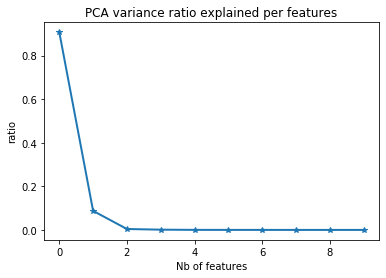

In [0]:
to_shrink = ['Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto']

df_to_shrink = df_filtered[to_shrink]
# because we have ',' instead of '.'
# df_to_shrink = df_to_shrink.applymap(lambda x : x.replace(',', '.'))

pca = PCA()
pca.fit(df_to_shrink)
print("PCA variance explained: \n{}".format(pca.explained_variance_ratio_))


# Todo: drop the income and education
plt.plot(figsize=(6, 6));
plt.plot(pca.explained_variance_ratio_, '-*',linewidth=2)
plt.title("PCA variance ratio explained per features");
plt.ylabel('ratio');
plt.xlabel('Nb of features');
plt.show();

# we only select one feature
pca = PCA(n_components=1)
df_shrinked = pca.fit(df_to_shrink).transform(df_to_shrink)

From previous plots we know that the accessibilties are correlated. That is why the pca give a really good variance explained even with only one feature (90%). That is why it seems reasonable to keep only the first feature of the pca to replace all the accessibility variable. In the later (explanatory analysis) we will explore the accessibility variables. 

### **Preliminary feature selection**

From the previous analysis, we will select the variables that seem relevant for the moment. 

In [0]:
# feature selection from the plots and the PCA
to_remove = ['Dist_salida_Autop_MC_KM'] + to_shrink

selected_df = df_filtered.drop(columns=to_remove)
selected_df['Acc_PCA'] = df_shrinked

In [0]:
print("Columns: {}".format(selected_df.columns.to_list()))
print("Dataframe shape: {}".format(selected_df.shape))

Columns: ['CLASE', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'CLUSTER7', 'CLUSTER2', 'Acc_PCA']
Dataframe shape: (16074, 10)


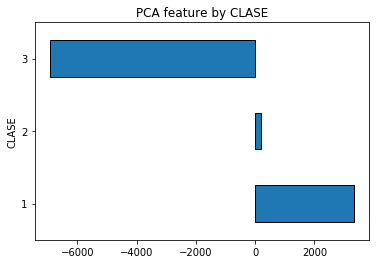

In [0]:
# Checking the new features
selected_df.groupby('CLASE').Acc_PCA.mean().plot(kind='barh', edgecolor='black');
plt.title("PCA feature by CLASE");

From this plot, we justify again the use of PCA. The feature is quite differentiating of the three values of CLASE. 

## **Visual analysis**


Lets visualize our dataset, using the coordinates given for each entry.

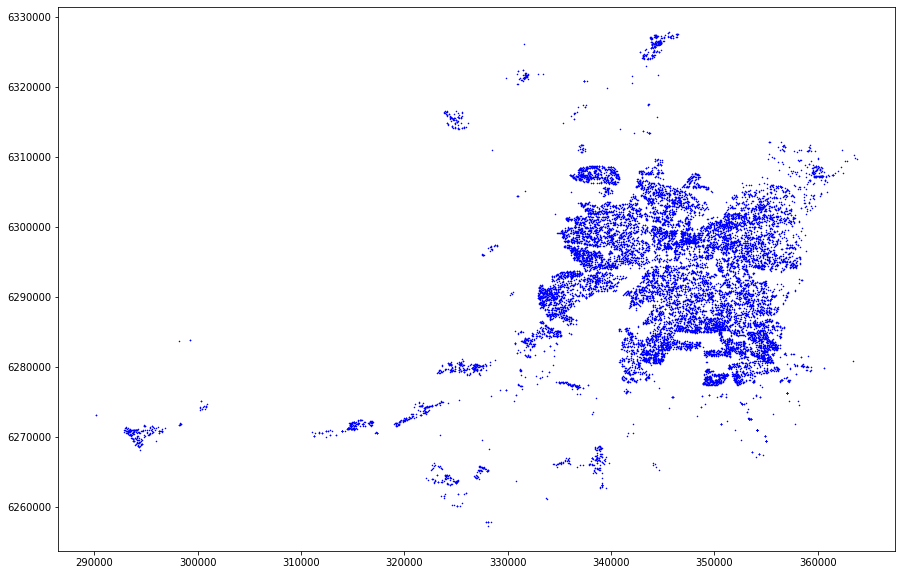

In [0]:
fig = plt.figure(figsize=(15,10))
plt.plot(df['DirCoordX'], df['DirCoordY'], '*', color='b', markersize=1);

The map looks okay, but the coordinates are a little bit odd, they don't correspond to the real world coordinates. We will have to change them to determine train and test set. This can be done using Python Projections, we just have to change the corresponding coordinate reference system given by the EPSG number (“European Petroleum Survey Group”). We can also use different colors for train and test set.

Converting coordinate systems: https://gis.stackexchange.com/questions/78838/converting-projected-coordinates-to-lat-lon-using-python

In [0]:
df_formap = df.copy();
inProj, outProj = Proj(init='epsg:32719'), Proj(init='epsg:4326'); #changing the projecting format 
df_formap['DirCoordX'], df_formap['DirCoordY'] = transform(inProj, outProj, df_formap['DirCoordX'].tolist(), df_formap['DirCoordY'].tolist()); #applying the formating change

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [0]:
# split dataframe into a training and a testing one
max_x, min_x = -70.6, -70.7
max_y, min_y = -33.4, -33.5
train_filter = (min_x <= df_formap['DirCoordX']) & (df_formap['DirCoordX'] <= max_x) & (min_y <= df_formap['DirCoordY']) & (df_formap['DirCoordY'] <= max_y)
df_train_map = df_formap[~train_filter]
df_test_map = df_formap[train_filter]

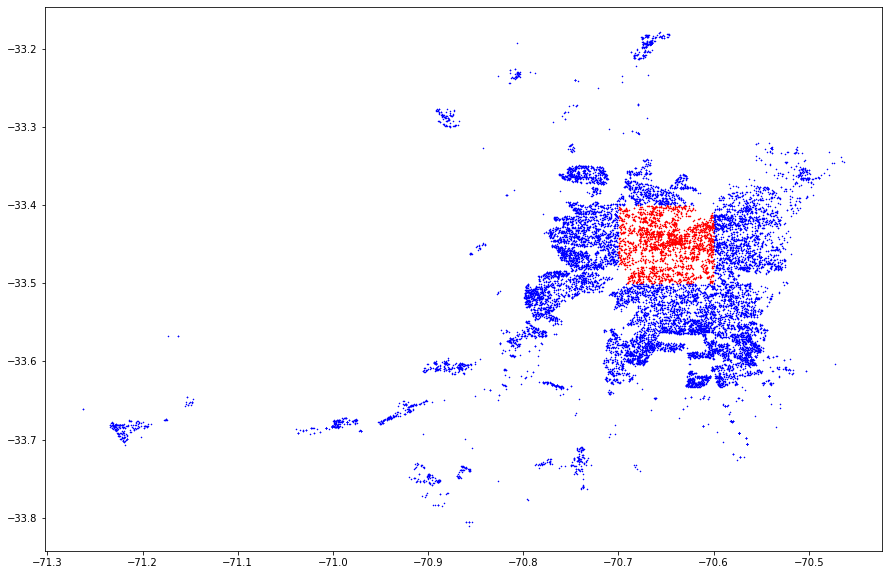

In [0]:
# visualize the distribution of the two sets
plt.figure(figsize=(15,10))
plt.plot(df_train_map['DirCoordX'], df_train_map['DirCoordY'], '*', color='b', markersize=1);
plt.plot(df_test_map['DirCoordX'], df_test_map['DirCoordY'], '*', color='r', markersize=1);

Alternatively, we can give the points different colors for the CLASE they correspond to and show which part of the map is our test set, given by a rectangle. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


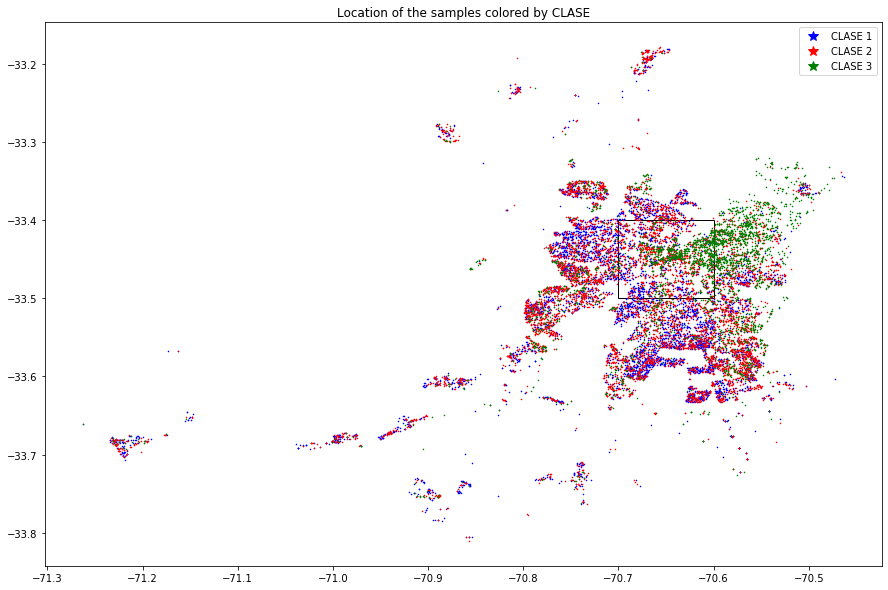

In [0]:
fig = plt.figure(figsize=(15,10))
plt.plot(df_formap.loc[df_formap['CLASE']==1]['DirCoordX'], df_formap.loc[df_formap['CLASE']==1]['DirCoordY'], '*', color='b', markersize=1, label="CLASE 1");
plt.plot(df_formap.loc[df_formap['CLASE']==2]['DirCoordX'], df_formap.loc[df_formap['CLASE']==2]['DirCoordY'], '*', color='r', markersize=1, label="CLASE 2");
plt.plot(df_formap.loc[df_formap['CLASE']==3]['DirCoordX'], df_formap.loc[df_formap['CLASE']==3]['DirCoordY'], '*', color='g', markersize=1, label="CLASE 3");

ax = fig.add_subplot(1, 1, 1)
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False));
plt.legend(markerscale=10);
plt.title('Location of the samples colored by CLASE')
plt.show();

We can see that CLASE 3 entries are dominant in the Northeast corner, whereas CLASE 1 and 2 are more present in the other locations. We can calculate the ratios of the CLASE present in the map overall, as well as in train and test set.

In [0]:
max_x, min_x = -70.6, -70.7
max_y, min_y = -33.4, -33.5

# split dataframe into a training and a testing one
train_filter = (min_x <= df_formap['DirCoordX']) & (df_formap['DirCoordX'] <= max_x) & (min_y <= df_formap['DirCoordY']) & (df_formap['DirCoordY'] <= max_y)

df_train_map = df_formap[~train_filter]
df_test_map = df_formap[train_filter]

In [0]:
print("Fraction of CLASE 1 in the data set:", len(df_formap.loc[df_formap['CLASE']==1])/len(df_formap))
print("Fraction of CLASE 2 in the data set:", len(df_formap.loc[df_formap['CLASE']==2])/len(df_formap))
print("Fraction of CLASE 3 in the data set:", len(df_formap.loc[df_formap['CLASE']==3])/len(df_formap))
print()
print("Fraction of CLASE 1 in the train nset:", len(df_train_map.loc[df_train_map['CLASE']==1])/len(df_train_map))
print("Fraction of CLASE 2 in the train set:", len(df_train_map.loc[df_train_map['CLASE']==2])/len(df_train_map))
print("Fraction of CLASE 3 in the train set:", len(df_train_map.loc[df_train_map['CLASE']==3])/len(df_train_map))
print()
print("Fraction of CLASE 1 in the test set:", len(df_test_map.loc[df_test_map['CLASE']==1])/len(df_test_map))
print("Fraction of CLASE 2 in the test set:", len(df_test_map.loc[df_test_map['CLASE']==2])/len(df_test_map))
print("Fraction of CLASE 3 in the test set:", len(df_test_map.loc[df_test_map['CLASE']==3])/len(df_test_map))

Fraction of CLASE 1 in the data set: 0.3720293641906184
Fraction of CLASE 2 in the data set: 0.43635684957073534
Fraction of CLASE 3 in the data set: 0.19161378623864625

Fraction of CLASE 1 in the train nset: 0.3970413321439191
Fraction of CLASE 2 in the train set: 0.43577163247100803
Fraction of CLASE 3 in the train set: 0.16718703538507285

Fraction of CLASE 1 in the test set: 0.2437070938215103
Fraction of CLASE 2 in the test set: 0.43935926773455375
Fraction of CLASE 3 in the test set: 0.3169336384439359


We can see that the classes are not evenly distributed in the dataset. Moreover, it seems that the fraction of CLASE 3 is much higher in the test set than the trainset. On the other hand. fraction of CLASE 1 is much lower in the test set compared to the train set.

### **Visual analysis using zone shapefiles**


#### **Preparation**
First, we will make use of the zone shapefiles attached as a part of the challenge to see if we can see some patterns by visualizing the data on the map. The shape file can be manipulated using GeoPandas package. For the begining, we will read the given .shp file and see how it looks like.

Inspired by: https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

Number of geometries: 866


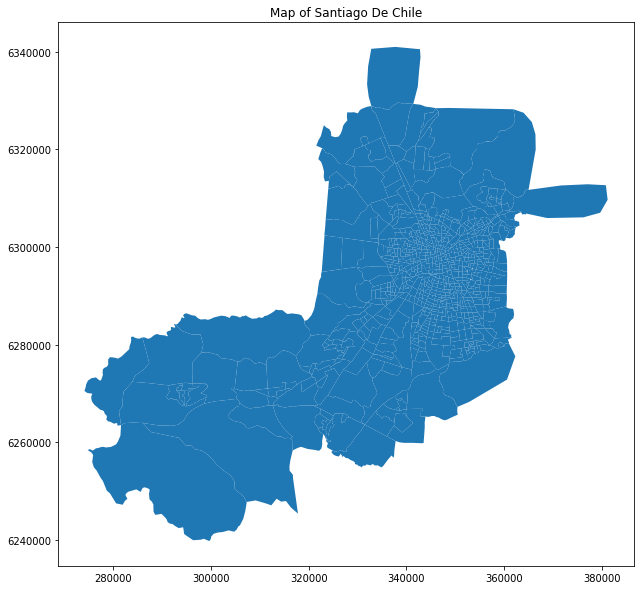

In [0]:
map = gpd.read_file(os.path.join(folder_shape_files, files[4])) #read the file from the drive
print("Number of geometries:", len(map))
ax = map.plot(figsize=(15,10)); #plot the map
ax.set_title('Map of Santiago De Chile');

We can see that there are 866 geometries in total. Let's take a look if the geometries correspond to the entries in our dataframe, we will plot them over each other. However, first we need to change the coordinate system. This was learned from https://automating-gis-processes.github.io/CSC/notebooks/L2/projections.html

In [0]:
map = map.to_crs(epsg=4326) #different type of coding (just the coordinates change)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


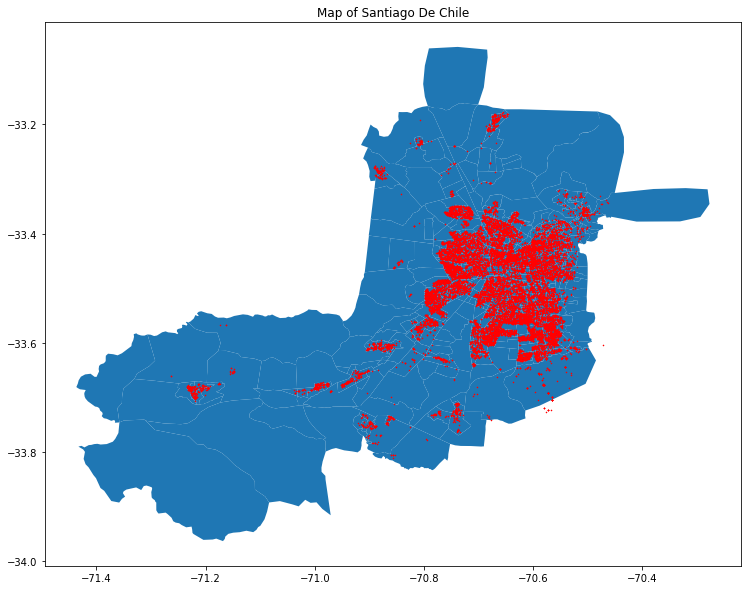

In [0]:
ax = map.plot(figsize=(15,10));
plt.plot(df_formap['DirCoordX'],df_formap['DirCoordY'], '*', color='r', markersize=1);
ax.set_title('Map of Santiago De Chile');

We see that the zones correspond to the entries in the dataset, which is great. There are som entries outside of any geometry in the Southwest corner, we will deal with them later. Let's take a closer look at map shapefile itself, which is a GeoPandas dataframe.

In [0]:
map.head()

ID    Com  ... Excluir                                           geometry
0  318.0  13114  ...       1  POLYGON ((-70.50243 -33.41327, -70.50161 -33.4...
1  311.0  13114  ...       0  POLYGON ((-70.48181 -33.38163, -70.48239 -33.3...
2  301.0  13114  ...       0  POLYGON ((-70.50838 -33.38215, -70.50748 -33.3...
3  734.0  13301  ...       0  POLYGON ((-70.69606 -33.23737, -70.69540 -33.2...
4  330.0  13115  ...       0  POLYGON ((-70.50891 -33.36313, -70.50852 -33.3...

[5 rows x 6 columns]

It seems every entry corresponds to a geometry with unique ID "ID", which belongs to some comuna with name given by "Comuna" and ID given by "Com". Lets take a look how many zones are there:

In [0]:
print("Number of zones (according to 'Com'):",len(map['Com'].unique()))

Number of zones (according to 'Com'): 45


This should correspond to number of comuna names, lets check.

In [0]:
print("Number of zones (according to 'Comuna'):",len(map['Com'].unique()))

Number of zones (according to 'Comuna'): 45


Lets take a look how are the zones distributed throughout the map.


No handles with labels found to put in legend.


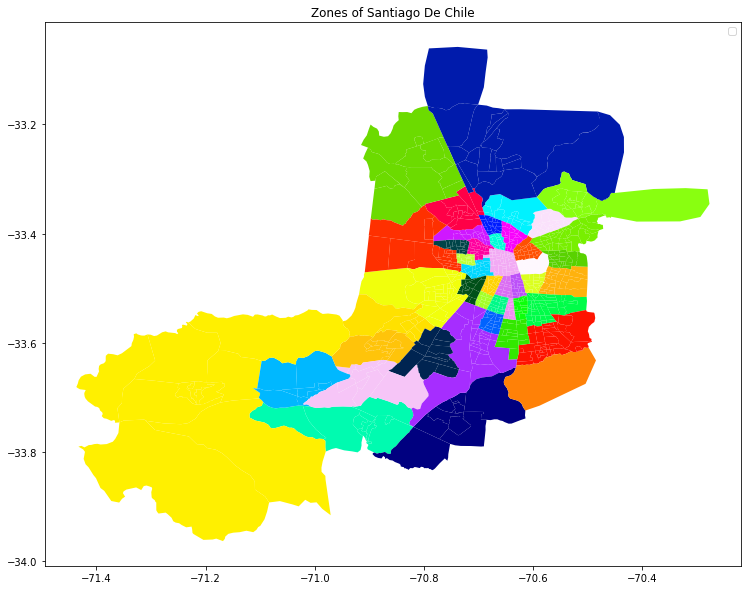

In [0]:
fig, ax = plt.subplots(1, figsize=(15, 10))
map.plot(column='Comuna',
            linewidth=0.8, 
            ax=ax,
            cmap='gist_ncar',
            #edgecolor='0.8',
            )
ax.set_title('Zones of Santiago De Chile');
#ax.axis('off')

Eventhough some zones seem to have the same color, there is one color per zone. 

If we take a look back at the head of the map dataframe, we can see the "Excluir" column, which should identify entries to be exluded. Let's try excluding the variables and see what remains. 

Number of geometries with exlcusion: 705


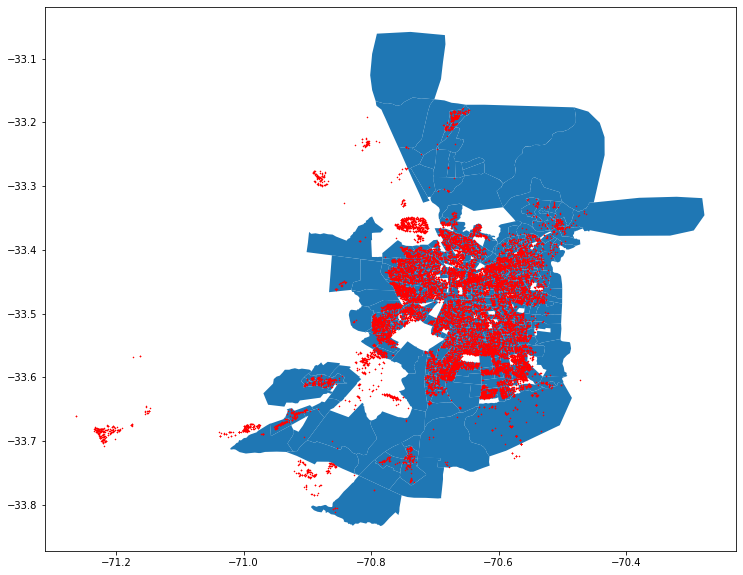

In [0]:
map_exluir = map[map['Excluir'] == 0];
print("Number of geometries with exlcusion:", len(map_exluir))
ax = map_exluir.plot(figsize=(15,10));
plt.plot(df_formap['DirCoordX'],df_formap['DirCoordY'], '*', color='r', markersize=1);

We see that if we exlude the geometries, there will be far more entries without a geometry. Therefore, we decide to keep all the zones to have a more complete analysis.


Now, it would be interesting, if we could link the map dataset with our households dataset. We will run a function which will find the zone corresponding to every entry in our househols data according to the geometry. First, we access the geometry and other attributes of the shapefile using Python Shapefile Library (PyShp). 

In order to do this, we have to access the shape file with a shapefile reader. However, the original shapefile still uses the old coordinates. If we wanted to change this, we would have to save the map dataframe into a shapefile. 

In order not to complicate things, we can run the zone classification using the original shapefile with the old coordinates, but we have to use the old coordinates of the household dataset as well. We will create an array containing all the zones and merge it with the dataframe containing the new coordinates. 

In [0]:
# reading shapefile and collecting info
sf = shapefile.Reader(os.path.join(folder_shape_files, files[4])) 

shapes = sf.shapes() #geometry of the zones
records = sf.records() #attributes of the zones
coordX = np.array(df['DirCoordX']) #change to numpy array just to be sure
coordY = np.array(df['DirCoordY'])

Now what we found out with various test we ran, which we did not include it here for simplicity, is that some polygon geometries overlap, but if they do, they always belong to the same Comuna, which has its unique ID "Com". Therefore, it is safe to just assign one (first) Comuna ID to every entry in our dataframe, because overlaping is just because one entry belongs to more polygons, but they are all the same Comuna. 

In [0]:
zones = []
for i in range(len(df_formap)): #all entries
    assigned = False
    for j in range(len(shapes)): #go through all zones
        if coordX[i]>=shapes[j].bbox[0] and coordX[i]<=shapes[j].bbox[2] and coordY[i]>=shapes[j].bbox[1] and coordY[i]<=shapes[j].bbox[3]: #if entry belongs to the polygon
            zones.append(records[j][1]) #assign first zone ID 'Com'
            assigned = True
            break 
    if not assigned:
      print(i)

9329
9362


Since two points are not in any zone, we remove them for further analysis.

In [0]:
df_formap.drop([9329, 9362], axis=0, inplace=True)

assert len(df_formap) == len(zones)

df_formap['zone'] = zones

Let's also see how many entries there are per zone.

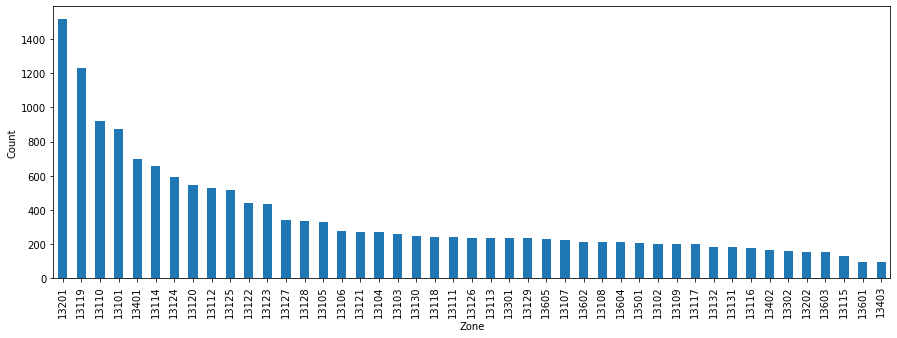

In [0]:
df_formap['zone'].value_counts().plot(kind='bar', figsize=(15,5));
plt.xlabel("Zone");
plt.ylabel("Count");

#### **Testing**
Everything should be prepared for the analysis now. First we pick up one parameter, lets start with "MontoArr" which is monthly dwelling rent in chillean peso. We are going to calculate a mean for every zone, merge it with the map frame and plot it. Test set is again going to be visualized by a rectangle. 

In [0]:
MontoArr=df_formap.groupby('zone')['MontoArr'].mean() #calculates mean for the zones
df_MontoArr=pd.DataFrame(data=MontoArr) #create dataframe
df_MontoArr.reset_index(inplace=True) #make zone a column 
df_MontoArr.head()

zone       MontoArr
0  13101  186401.203895
1  13102  149579.472637
2  13103  113611.969112
3  13104  135318.352060
4  13105  113973.130303

In [0]:
merged = map.set_index('Com').join(df_MontoArr.set_index('zone')) #merge with map dataset
merged.head()

ID  ...       MontoArr
13101  22.0  ...  186401.203895
13101  46.0  ...  186401.203895
13101  23.0  ...  186401.203895
13101  32.0  ...  186401.203895
13101  34.0  ...  186401.203895

[5 rows x 6 columns]

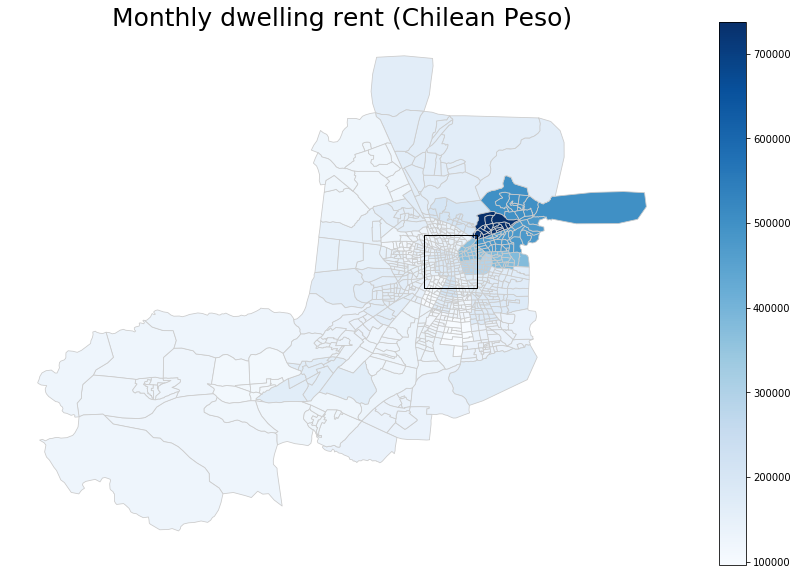

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'MontoArr'

# set the range for the choropleth
vmin, vmax = min(MontoArr), max(MontoArr)

fig, ax = plt.subplots(1, figsize=(15, 10))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')
ax.set_title('Monthly dwelling rent (Chilean Peso)', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False));
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)


We can see that the rent peeks in the Northeast corner of Santiago. Rest of the city seems to have 3 times lower rent. 

#### **Plotting different attributes for the zones**

Now lets analyze all the other parameters of our households dataset by calculating means for the zones and plotting them,

In [0]:
map_plots=map.copy() #just to be sure

In [0]:
#variables to be plotted on the map
columns_formap=df_formap.columns.tolist()
variables_plotted = columns[columns.index('Sector'):columns.index('Acc_Servicios_auto')]
variables_plotted.remove('DirCoordX')
variables_plotted.remove('DirCoordY')
variables_plotted.remove('MontoArr')
print(variables_plotted)

['Sector', 'IngresoHogar', 'Factor', 'AnosEstudio', 'CLASE', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM', 'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub', 'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto', 'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto']


In [0]:
def zonemap(variable,dataframe,to_be_merged): #takes a variable from a frame, calculates mean for the zones and merges with given frame
    Frame=dataframe.groupby('zone')[variable].mean()
    df_Frame=pd.DataFrame(data=Frame)
    #df_Frame.reset_index(inplace=True)
    to_be_merged = to_be_merged.join(df_Frame)
    return to_be_merged

In [0]:
for i in variables_plotted: #applies the function
    # print(i)
    merged=zonemap(i,df_formap,merged)

In [0]:
# function for moving along the sublots
def next_step(previous, limx, limy):
  """given previous tuple, return the next tuple on a defined grid"""
  return_x, return_y = previous
  if previous[1]+1 < limy:
    return_y += 1
    return return_x, return_y
  else:
    return return_x+1, 0

In [0]:
#function for plotting
def plot_variable(variables_plotted,frame):
  fig, ax_tot = plt.subplots(7, 3, figsize=(30, 30))
  grid_loc = (0, 0)
  for i, variable in enumerate(variables_plotted):
      #ax = ax_tot[i%7, i%3]
      ax = ax_tot[grid_loc]
      grid_loc = next_step(grid_loc, 7, 3)
      vmin, vmax = min(frame[variable]), max(frame[variable])
      frame.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
      
      ax.axis('off')

      ax.set_title(variable, \
                fontdict={'fontsize': '15',
                          'fontweight' : '3'})
      ax.add_patch(
      patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False));

      sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
      sm._A = []
      cbar = plt.colorbar(sm, ax=ax)
  plt.tight_layout()

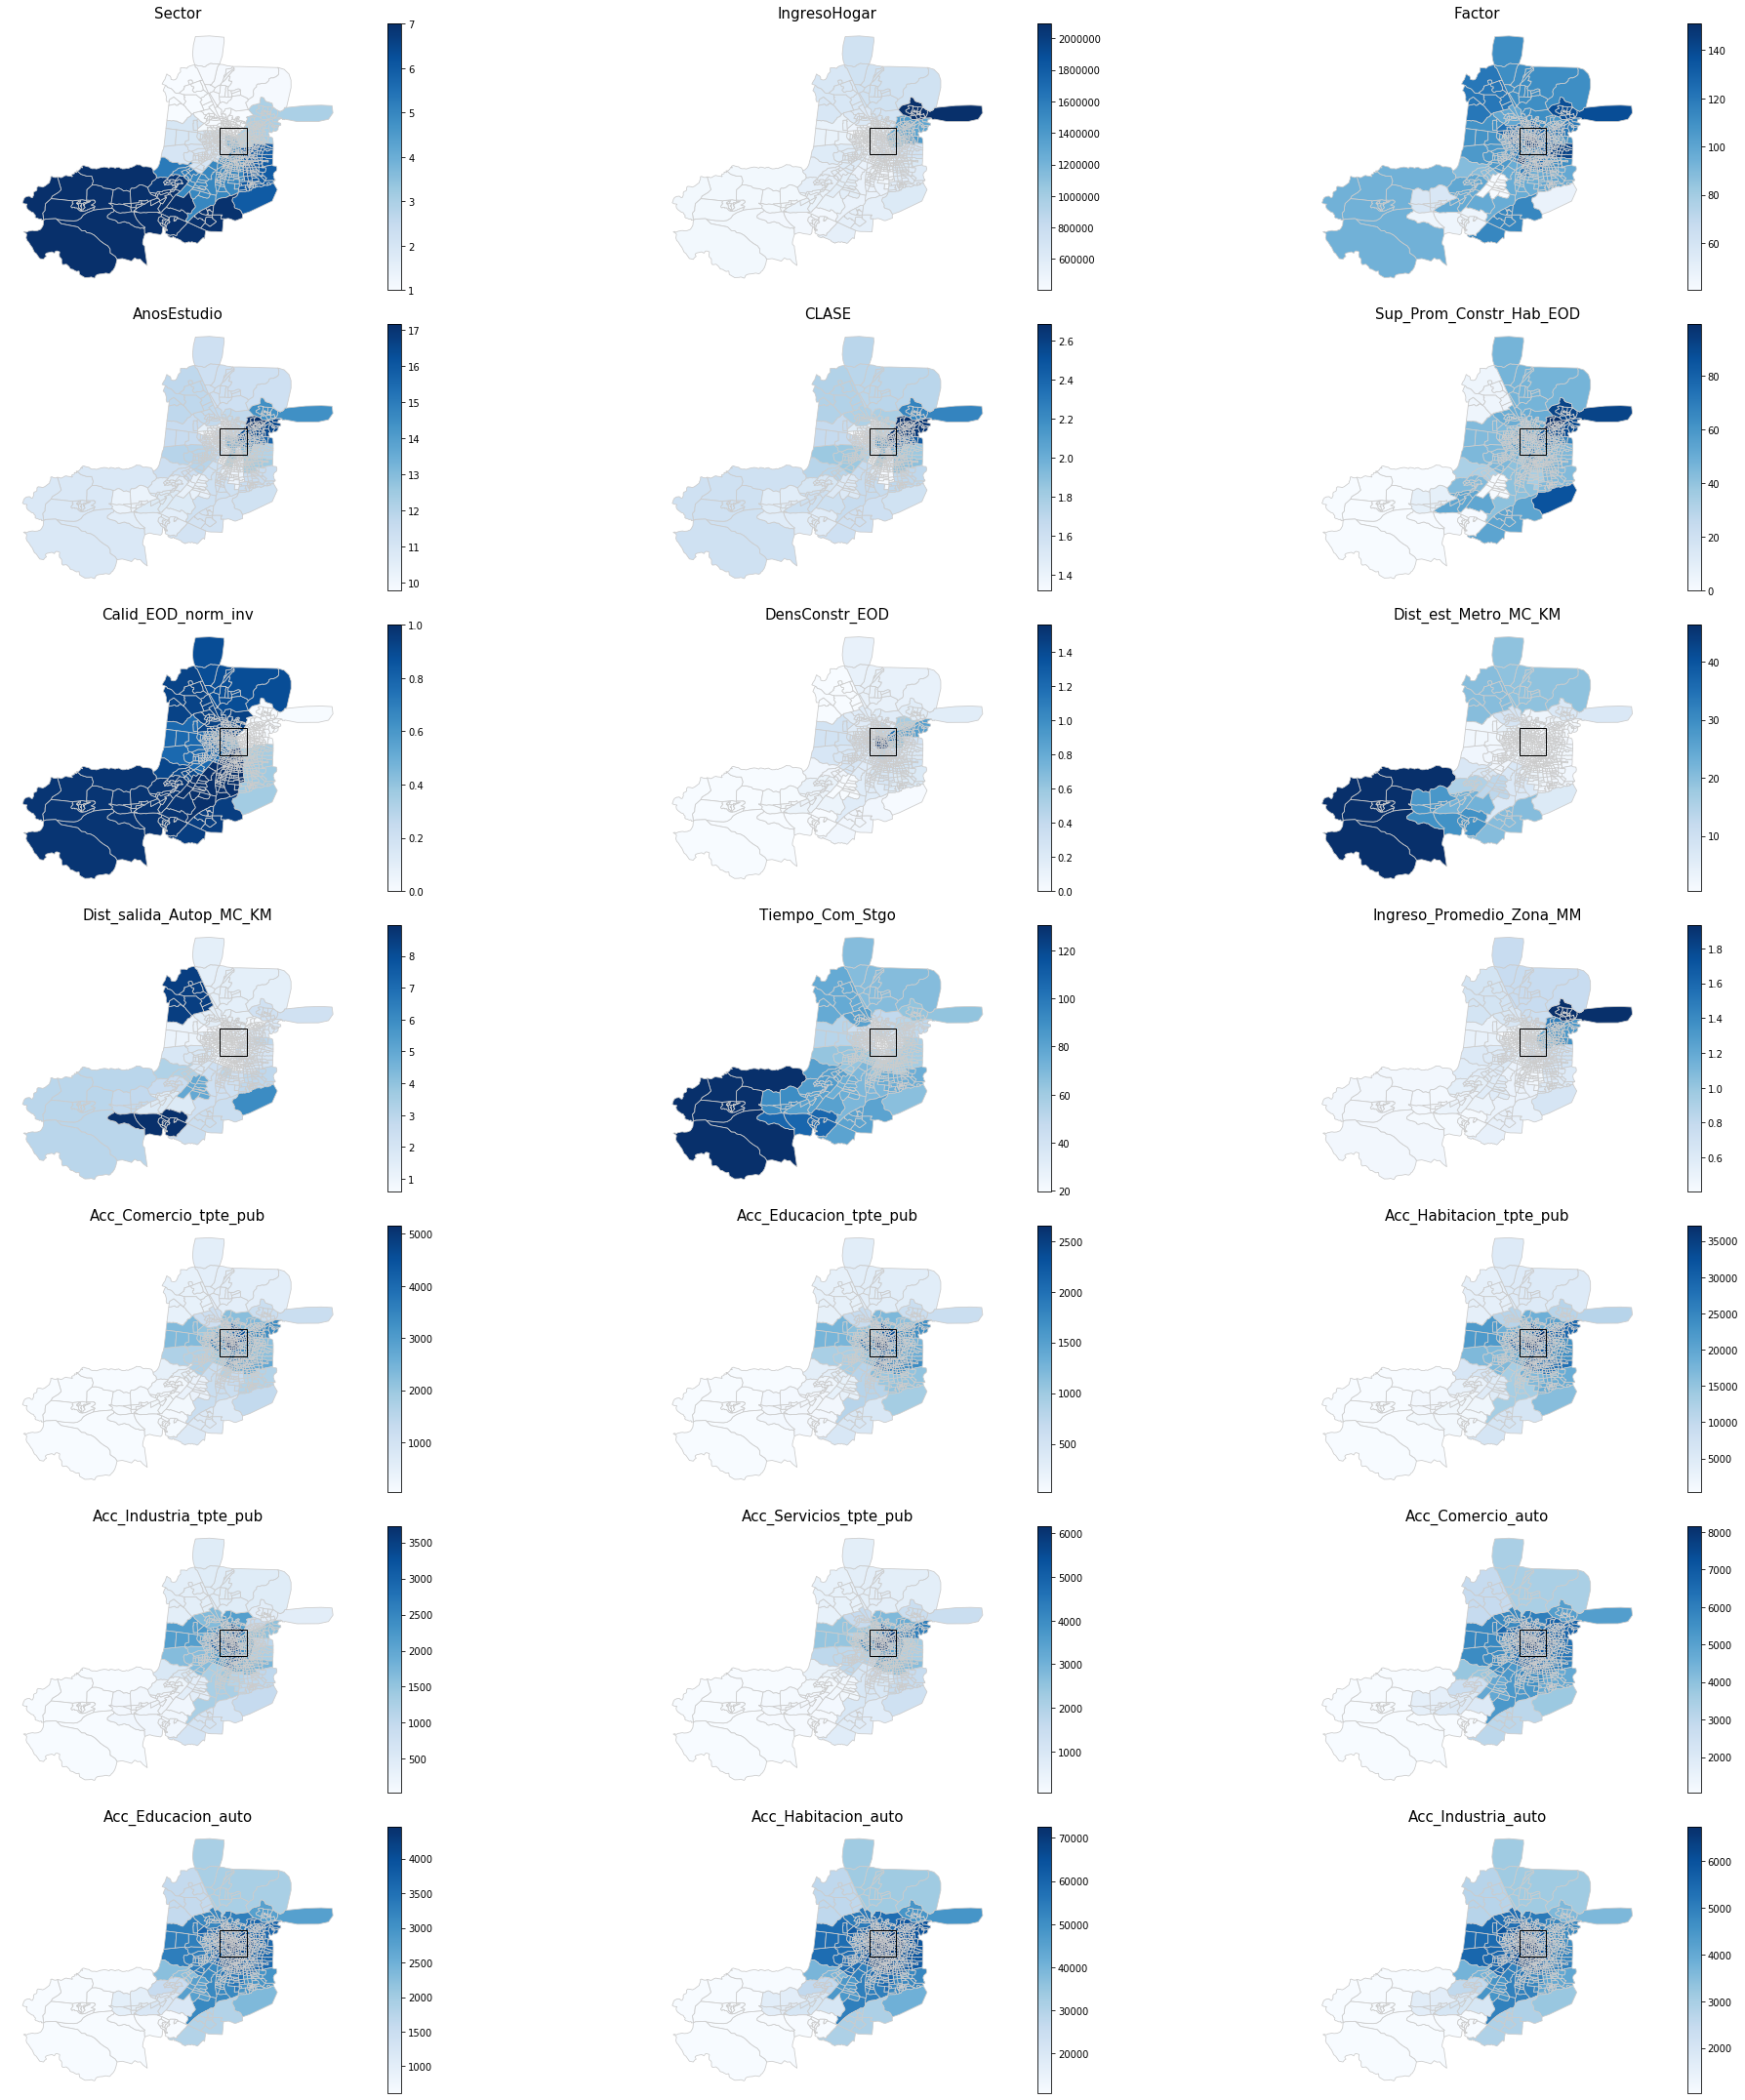

In [0]:
plot_variable(variables_plotted, merged)

Lets analyze the results a little bit. 

First figure (Sectors) just shows the distribution of the zones into 7 different exogenous sectors. These are given by the author of the data set. 

Second figure (IngresoHogar) shows the household income in chillean peso. We can see that the income peeks in the northeast corner. This correlates with the very first figure shown in testing (MontoArr), since it can be expected that the people with highest income pay the highest rent.

Expansion factor (figure 3) represents the weight of this kind of family in the population. It is more distributed throughout the city. There are some zones with 0 expansion factor in the south. The highest seems to be in the northeast corner.

AnosEstudio, years of formal education of head of household is also the highest in northeast corner. This could again correlate with higher income.

Figure 5, CLASE can be seen as averaged CLASE per zone version of the 'Location of the samples colored by CLASE' plot in visual analysis section. As discussed before, CLASE 3 is more dominant in the northeast corner. The rest of the north shows an average of CLASE 2 and the south is dominated by CLASE 1.

Sup_Prom_Constr_Hab_EOD is the average built surface of residential units in zone. It is the highest in the east, overall high in the centre and lowest in the southwest. 

Calid_EOD_norm_inv - average construction quality of residential units in zone in inverse is the lowest in the northwest corner and very high in the rest of the zones. Since it is inverse, it means the highest quality of residential units is in the northeast corner. This again correlates with the higher income and higher rent. 

DensConstr_EOD - built density in zone (built surface divided by zone surface) is very high in the centre and very low everywhere else. 

Dist_est_Metro_MC_KM - distance to nearest subway station (km). It seems the metro covers the centre well, but not the outskirts.

Dist_salida_Autop_MC_KM - distance to nearest highway exit (km) shows interesting pattern. Overall the north and centre seems to be covered well, there are though multiple zones with bad accessibility to highway. 

Tiempo_Com_Stgo - travel time to CBD (min) is as expected a function the distance from the centre. 

Ingreso_Promedio_Zona_MM - average zonal income (Million Chilean Peso) is as expected correlated to IngresoHogar.

The last 9 figures, accebilities to (commerce, education, habitational, industry, services) in both transit and car show almost the same pattern and are a function of distance form the city centre, which can be expected.




#### **Shapefile visualization conclusion**

There are certain patterns to be seen from the visualization. Northeast corner of the city is probably the living area of the wealthy citizens characterized by high income, high rent, high construction quality and the most years of formal education. In many aspects, this residential area differs from the rest of the city a lot. Part of this district is a part of the test set. 

Furthermore, there are many parameters which seem like a function of distance from the city centre. This can be seen with the accessibilities, distance to metro and travel time to city centre. One can say it is intuitive, cities are usually centralised and the most activities are focused in the centre itself, which might explain why the accessibility lowers the further you are from the centre. 

On the other hand, this raises a question whether the most valid approach is to split the dataset such that the test set is in the city centre itself, while the train set is outside, since the parameters depend on the geometry and differ significantly in and out of the city centre.



## **Visualization bonus**

This section includes additional external datasets used to further explore and analyse patterns in the city.

#### **Metro stations**

Looking at the figure Dist_est_Metro_MC_KM (distance to nearest subway station in km), one might get interested, where the metro stations are in the city. A few datasets were obtained from https://datos.gob.cl/dataset, one of them with the positions of the metro stations (https://datos.gob.cl/dataset/33355). This data set was preprocessed in excel and subsequently uploaded to github. It consisted of 2 sheets. They had to be saved as csv files separately.

In [0]:
metro = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/3d43cdddfd845e3c355fdc23219235a3/raw/33b5534df96978b8a7976eea22e005bd3a8b001b/metro.csv", sep=';', error_bad_lines=False);
print(len(metro))
metro.head()

94


CODIGO ENTIDAD   NOMBRE FANTASIA  ...    NORTE   LONGITUD    LATITUD
0     L1   METRO         ALCANTARA  ...  6301527 -70.589686 -33.415439
1     L1   METRO           ECUADOR  ...  6296835 -70.701086 -33.456267
2     L1   METRO           EL GOLF  ...  6301383 -70.595856 -33.416658
3     L1   METRO   ESCUELA MILITAR  ...  6301661 -70.584637 -33.414291
4     L1   METRO  ESTACION CENTRAL  ...  6297466 -70.679149 -33.450875

[5 rows x 10 columns]

In [0]:
metro2 = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/9ffc403b1d018a5ae4bcba5046732a2b/raw/34ed55d27b2e92aaa90b51b42576f07889e5ac0a/metro2.csv", sep=';', error_bad_lines=False);
print(len(metro2))
metro2.head()

42


CODIGO ENTIDAD NOMBRE FANTASIA  ...    NORTE   LONGITUD    LATITUD
0     L1   METRO    BAQUEDANO L1  ...  6299042 -70.633119 -33.437277
1     L1   METRO   LOS HEROES L1  ...  6297979 -70.661705 -33.446487
2     L1   METRO         NEPTUNO  ...  6297327 -70.722646 -33.451536
3     L1   METRO    SAN PABLO L1  ...  6298000 -70.723118 -33.445454
4     L1   METRO     SANTA LUCIA  ...  6298440 -70.645204 -33.442554

[5 rows x 10 columns]

Lets plot them on the map. 

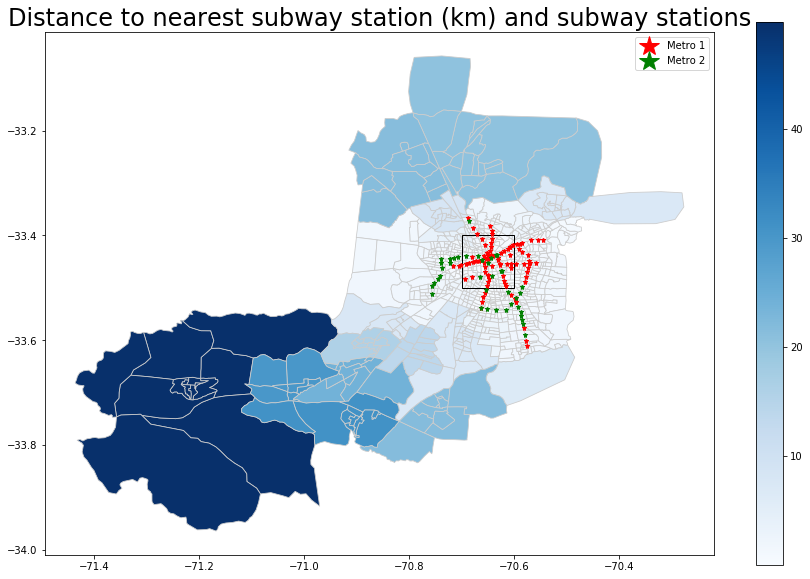

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Dist_est_Metro_MC_KM'

# set the range for the choropleth
vmin, vmax = min(df_formap['Dist_est_Metro_MC_KM']), max(df_formap['Dist_est_Metro_MC_KM'])

fig, ax = plt.subplots(1, figsize=(15, 10))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

#ax.axis('off')
ax.set_title('Distance to nearest subway station (km) and subway stations', \
              fontdict={'fontsize': '24',
                        'fontweight' : '3'})
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False));
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.plot(metro['LONGITUD'],metro['LATITUD'], '*', color='r', markersize=5, label="Metro 1");
plt.plot(metro2['LONGITUD'],metro2['LATITUD'], '*', color='g', markersize=5, label="Metro 2");
plt.legend(markerscale=4);

It is indeed that some zones on the north and south are quite far from metro stations. Interestingly, some zones which appear to be close to metro have higher value of Dist_est_Metro_MC_KM parameter than others which seem to be further. It might be possible that new metro stations were built, the data set is from 2019, whereas the houshold data set is older (2012).

#### **Pharmacies and Supermarket Chains**

One could also examine accessibility to commerce. Definiton of commerce was not clearly specified, although we acquired a data set containing pharmacies Unimarc and super market stores Wallmart, in which you can load the transport Bip card. Source: https://datos.gob.cl/dataset/33353. This dataset was also preprocessed and uploaded to github. It will give us very narrow view how commerce might be distributed, but lets explore if there is any correlation.

In [0]:
retail = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/af7c1e92fa7fe2eb62b85de2300135e6/raw/a723fb090f58b0a2c390e8e9693a384696ab6bd9/retail20191120oficio-47702013.csv", sep=';', error_bad_lines=False);
retail.tail()

CODIGO  ENTIDAD  ...   LONGITUD    LATITUD
162     393  WALMART  ... -70.768076 -33.541184
163     398  WALMART  ... -71.126210 -33.402442
164     399  WALMART  ... -70.843050 -33.448053
165     400  WALMART  ... -70.577487 -33.425910
166     401  WALMART  ... -70.714935 -33.374448

[5 rows x 10 columns]

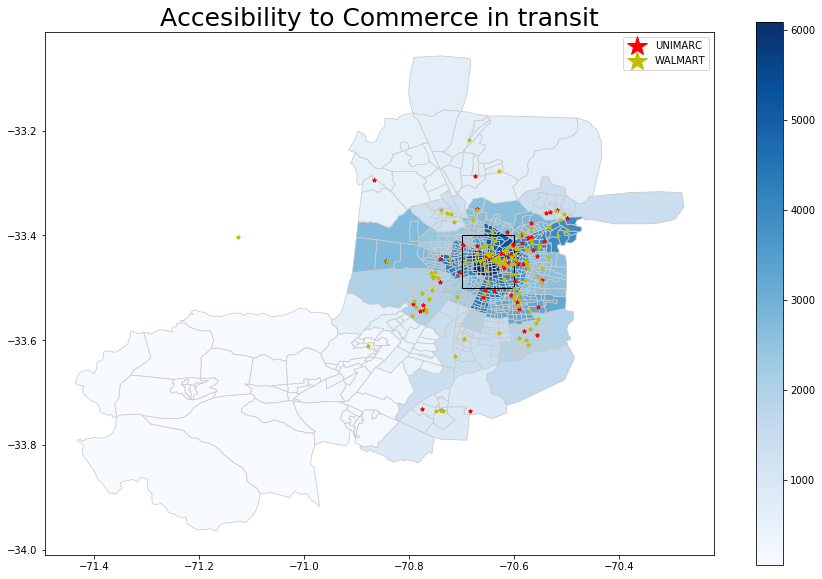

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Acc_Comercio_tpte_pub'

# set the range for the choropleth
vmin, vmax = min(df_formap['Acc_Comercio_tpte_pub']), max(df_formap['Acc_Comercio_tpte_pub'])

fig, ax = plt.subplots(1, figsize=(15, 10))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

#ax.axis('off')
ax.set_title('Accesibility to Commerce in transit', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False));
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.plot(retail.loc[retail['ENTIDAD']=='UNIMARC']['LONGITUD'], retail.loc[retail['ENTIDAD']=='UNIMARC']['LATITUD'], '*', color='r', markersize=4, label="UNIMARC");
plt.plot(retail.loc[retail['ENTIDAD']=='WALMART']['LONGITUD'], retail.loc[retail['ENTIDAD']=='WALMART']['LATITUD'], '*', color='y', markersize=4, label="WALMART");
plt.legend(markerscale=5);

The dataset found indeed looks correlated with the accesibility to commerce in transit. Most of the pharmacies Unimarc and super market stores Walmart are in the centre where the accessibility is the highest. As the accessibility lowers with distance from the city centre, both pharmacies and supermarkets become more sparse. 

#### **Presidential elections of 2017**

Lastly, Data Chile was examined for any interesting datasets https://es.datachile.io/about/data. We found data from presidential elections from 2017, showing total votes in comunas. It might be interesting to see in which comunas vote people the most. Original datsets were zipped, so we preprocessed them and put them to github again. 

In [0]:
comunaid = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/fbb29dcab1934d8006bfa707dd3e35c2/raw/62b29f430ad27f3343500acdae4b87eedbe052f2/comunas_id.csv", error_bad_lines=False);
print(len(comunaid))
comunaid.head()

348


region_id region_name  ...  comuna_tax_office_id   comuna_name
0          1    Tarapacá  ...                1204.0  Pozo Almonte
1          1    Tarapacá  ...                1203.0          Pica
2          1    Tarapacá  ...                1201.0       Iquique
3          1    Tarapacá  ...                1206.0         Huara
4          1    Tarapacá  ...                1210.0      Colchane

[5 rows x 6 columns]

In [0]:
presidents = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/7def0d2e5453c9a599c888b5c9a53e00/raw/2b3242d6073ec12d4123057510d6fb2282ce51be/presidenciales_2017_participacion_total.csv", error_bad_lines=False);
print(len(presidents))
presidents.head()

690


year  election_id  comuna_datachile_id  total_electores  total_votacion
0  2017            1                  113           160432           67847
1  2017            1                    5            51451           18775
2  2017            1                  191           140080           63937
3  2017            1                  295             9721            4893
4  2017            1                  244            11114            5549

First data set comunaid is going to be the link between our zones shape file and the presidential elections dataset. We will join zone shape file and zone on comuna name and the join with the presidential dataset on comuna_datachile_id. Presidential dataset contains 2 interesting columns: total_electores - number of voters and total_vacacion - number of people that went to vote. We will calculate the fraction of voters that voted from the total, which might be interesting later and then proceed with the merging and visualizations.

In [0]:
presidents['Percent_Voted']=presidents['total_votacion']/presidents['total_electores'];
print('Percent of people that voted is',presidents['Percent_Voted'].mean())
presidents.head()

Percent of people that voted is 0.46507300727596035


year  election_id  ...  total_votacion  Percent_Voted
0  2017            1  ...           67847       0.422902
1  2017            1  ...           18775       0.364910
2  2017            1  ...           63937       0.456432
3  2017            1  ...            4893       0.503343
4  2017            1  ...            5549       0.499280

[5 rows x 6 columns]

In [0]:
merged_presidents= map.set_index('Comuna').join(comunaid.set_index('comuna_name'))
merged_presidents=merged_presidents.dropna()
merged_presidents.head()

866
866
669


ID    Com  ...  comuna_customs_id  comuna_tax_office_id
Buin             788.0  13402  ...            13402.0               16403.0
Buin             787.0  13402  ...            13402.0               16403.0
Buin             784.0  13402  ...            13402.0               16403.0
Buin             783.0  13402  ...            13402.0               16403.0
Buin             789.0  13402  ...            13402.0               16403.0
Buin             785.0  13402  ...            13402.0               16403.0
Buin             792.0  13402  ...            13402.0               16403.0
Buin             791.0  13402  ...            13402.0               16403.0
Buin             790.0  13402  ...            13402.0               16403.0
Buin             786.0  13402  ...            13402.0               16403.0
Calera de Tango  795.0  13403  ...            13403.0               16402.0
Calera de Tango  793.0  13403  ...            13403.0               16402.0
Calera de Tango  802.0  13403  ...            13403.0               16402.0
Calera de Tango  801.0  13403  ...            13403.0               16402.0
Calera de Tango  800.0  13403  ...            13403.0               16402.0

[15 rows x 10 columns]

In [0]:
print('Number of zones without available data:',len(merged_presidents['Com'].unique()))

Number of zones with available data: 36


Unfortunately, there are no data available for 9 of the zones. We will however still proceed.

In [0]:
merged_presidents = merged_presidents.set_index('comuna_datachile_id').join(presidents.set_index('comuna_datachile_id'))
merged_presidents=merged_presidents.dropna()
merged_presidents.head()

1338
1338


ID    Com  ...  total_votacion  Percent_Voted
comuna_datachile_id                ...                               
14.0                 788.0  13402  ...           31854       0.473813
14.0                 788.0  13402  ...           33306       0.495411
14.0                 787.0  13402  ...           31854       0.473813
14.0                 787.0  13402  ...           33306       0.495411
14.0                 784.0  13402  ...           31854       0.473813

[5 rows x 14 columns]

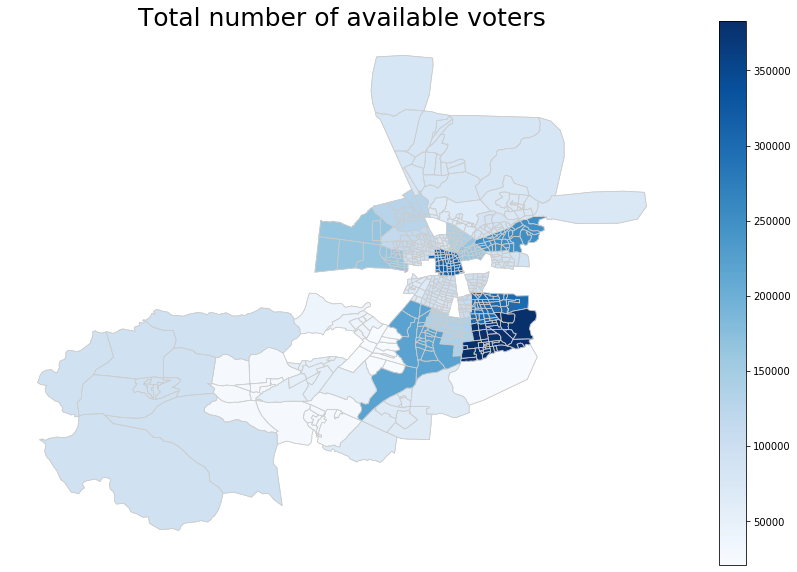

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'total_electores'

# set the range for the choropleth
vmin, vmax = min(merged_presidents['total_electores']), max(merged_presidents['total_electores'])

fig, ax = plt.subplots(1, figsize=(15, 10))
merged_presidents.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')
ax.set_title('Total number of available voters', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

We can see that the total number of available voters is the highest souther to the city center, as well as in the city center itself. Interestingly, total number of available voters is higher in the outer residential zones of the center, not the middle ones. 

Intuitively, these numbers should correspond to density of population. Therefore, maybe they should correlate to density of construction shown in DensConstr_EOD. This does not seem to be so given by visual comparison. 

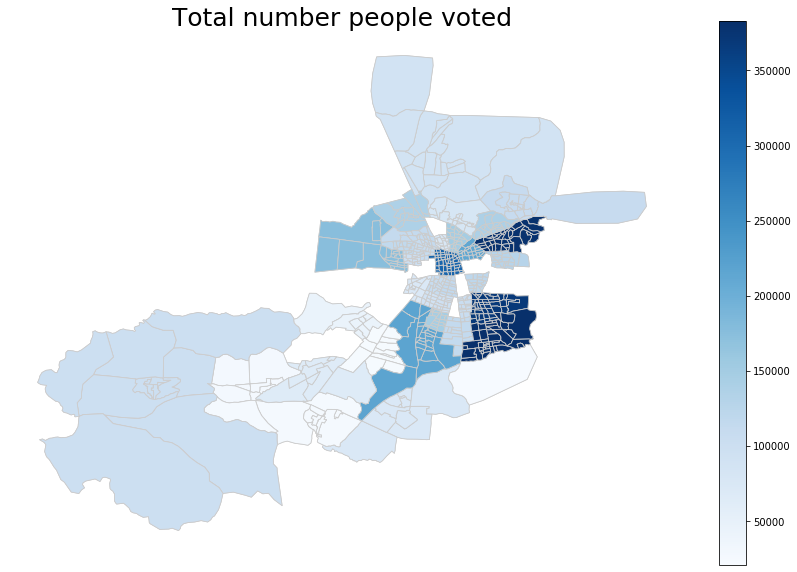

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'total_votacion'

# set the range for the choropleth
vmin, vmax = min(merged_presidents['total_votacion']), max(merged_presidents['total_votacion'])

fig, ax = plt.subplots(1, figsize=(15, 10))
merged_presidents.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')
ax.set_title('Total number of people voted', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

It can be seen that the number of people voting correlates with total number of available voters. This seems to be correct, since the more potential voters there are the more people will probably vote in total.

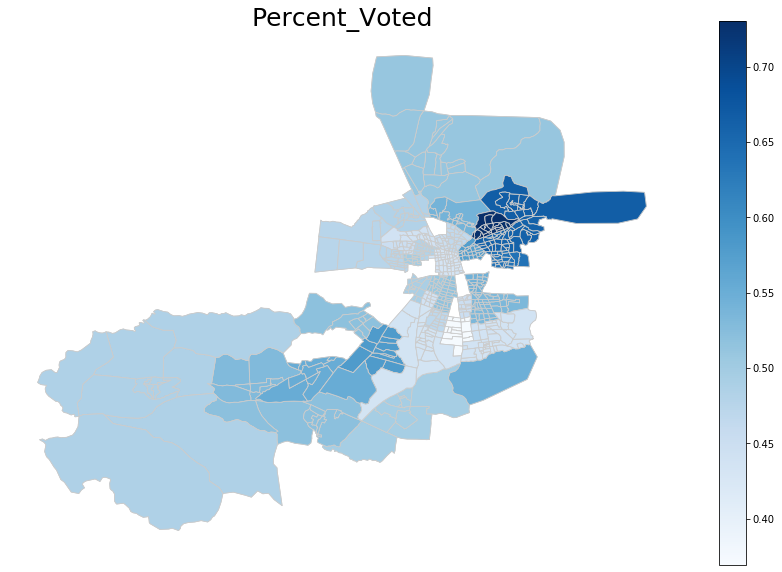

In [0]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Percent_Voted'

# set the range for the choropleth
vmin, vmax = min(merged_presidents['Percent_Voted']), max(merged_presidents['Percent_Voted'])

fig, ax = plt.subplots(1, figsize=(15, 10))
merged_presidents.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')
ax.set_title('Percent_Voted', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

This figure interestingely shows that districts with the highest numbers of potential voters in the south of city center and city center itself vote less on average than the other districts. 

Moreover, the ratio of the potential voters taking part in the elections is the highest in the northeast corner, which is defined by high income and years of education. This is an interesting correlation. One could possibly study, if there is a correlation between income and percent of people voting in a zone.